# LLM Multimodal Traffic Accident Forecasting



In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data as strings (so we can do string operations on it)
accidents_raw = pd.read_csv("/Users/pramitsahoo/Desktop/AI 23-25/2nd semester/EE5640/Project/FARS2021NationalCSV/accident.csv", encoding="ISO-8859-1", dtype=str)

# Identify unique non-numeric values in 'YEAR' column
valid_years = accidents_raw['YEAR'].str.isnumeric() == True
invalid_years = ~valid_years & accidents_raw['YEAR'].notna()

non_numeric_years = accidents_raw[invalid_years]['YEAR'].unique()
print("Non-numeric YEAR values:", non_numeric_years)

# Remove rows with the non-numeric YEAR values OR replace them with a valid value.
# Here, I'll just drop those rows for simplicity.
accidents_clean = accidents_raw[accidents_raw['YEAR'].notna() & accidents_raw['YEAR'].str.isnumeric()]

# Convert columns back to appropriate dtypes (especially the numeric ones)
accidents_clean['YEAR'] = accidents_clean['YEAR'].astype(int)

Non-numeric YEAR values: []


In [31]:
# Convert the YEAR, MONTH, and DAY columns to a datetime format
accidents_clean['DATE'] = pd.to_datetime(accidents_clean[['YEAR', 'MONTH', 'DAY']])

# Aggregate data at the daily frequency
daily_accidents = accidents_clean.groupby('DATE').size()

# Aggregate fatalities
daily_fatalities = accidents_clean.groupby('DATE')['FATALS'].sum()

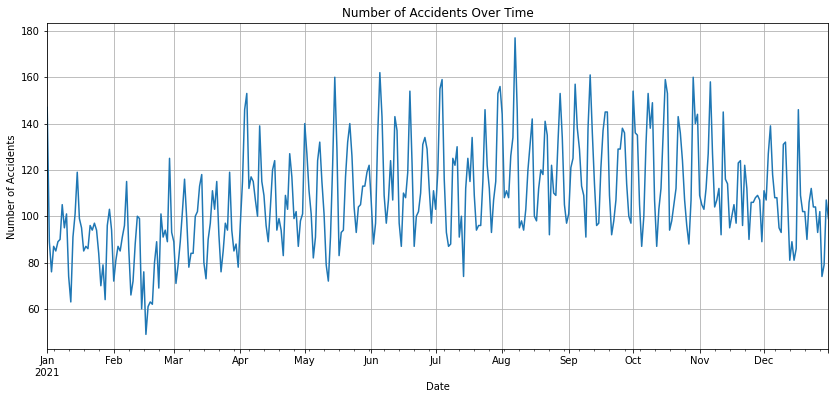

In [32]:
plt.figure(figsize=(14, 6))
daily_accidents.plot()
plt.title("Number of Accidents Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Accidents")
plt.grid(True)
plt.show()

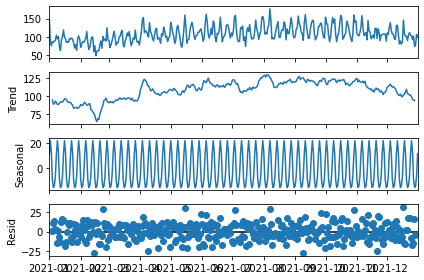

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Decomposing the time series
result = seasonal_decompose(daily_accidents, model='additive')

# Plotting the decomposed time series
result.plot()
plt.show()

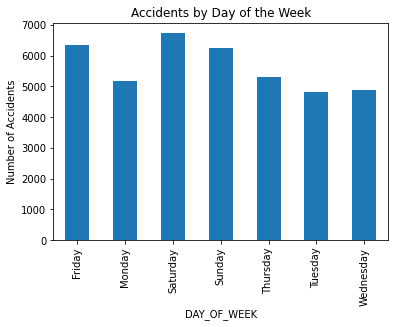

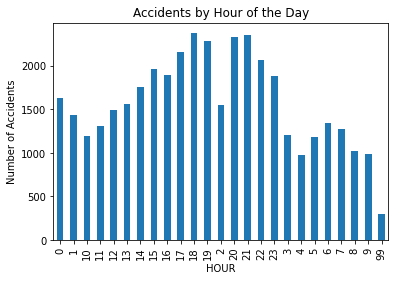

In [34]:
# Break down by days of the week
accidents_clean['DAY_OF_WEEK'] = accidents_clean['DATE'].dt.day_name()
weekday_counts = accidents_clean.groupby('DAY_OF_WEEK').size()

# Visualization
weekday_counts.plot(kind='bar')
plt.title('Accidents by Day of the Week')
plt.ylabel('Number of Accidents')
plt.show()

# Hourly patterns
hourly_counts = accidents_clean.groupby('HOUR').size()
hourly_counts.plot(kind='bar')
plt.title('Accidents by Hour of the Day')
plt.ylabel('Number of Accidents')
plt.show()

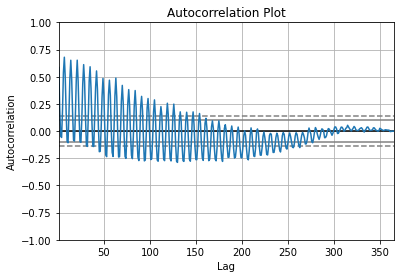

In [35]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(daily_accidents)
plt.title("Autocorrelation Plot")
plt.show()

In [36]:
def is_float_index(index):
    return index.dtype == float 

def is_int_index(index):
    return index.dtype.kind == 'i'


In [37]:
daily_accidents.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 365 entries, 2021-01-01 to 2021-12-31
Series name: None
Non-Null Count  Dtype
--------------  -----
365 non-null    int64
dtypes: int64(1)
memory usage: 5.7 KB


In [38]:
daily_accidents.head()

DATE
2021-01-01    147
2021-01-02     89
2021-01-03     76
2021-01-04     87
2021-01-05     85
dtype: int64

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Set frequency of DateTime index explicitly to daily if it's not already a PeriodDtype
if not isinstance(daily_accidents.index, pd.PeriodIndex):
    daily_accidents.index = pd.DatetimeIndex(daily_accidents.index).to_period('D')

# Display ACF and PACF to help in choosing ARIMA parameters
plt.figure(figsize=(12,4))
plot_acf(daily_accidents, lags=40)
plot_pacf(daily_accidents, lags=40)
plt.show()

# Fit the ARIMA model based on observed ACF and PACF
model = ARIMA(daily_accidents, order=(1,1,1))
fit_model = model.fit()

# Forecasting the next 30 days as an example
forecast_steps = 30
forecast = fit_model.forecast(steps=forecast_steps)

# Convert the Period index back to DateTime index for plotting
daily_accidents.index = daily_accidents.index.to_timestamp()

# Plotting the original time series and the forecast
plt.figure(figsize=(14,7))
plt.plot(daily_accidents.index, daily_accidents.values, label="Observed")
plt.plot(pd.date_range(start=daily_accidents.index[-1], periods=forecast_steps+1, closed='right'), forecast, color='red', label="Forecast")
plt.title("ARIMA Forecast of Daily Accidents")
plt.xlabel("Date")
plt.ylabel("Number of Accidents")
plt.legend()
plt.grid(True)
plt.show()


ImportError: cannot import name 'is_float_index' from 'statsmodels.compat.pandas' (/opt/anaconda3/lib/python3.9/site-packages/statsmodels/compat/pandas.py)

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Convert series to supervised learning format
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(daily_accidents.values.reshape(-1, 1))
series = series_to_supervised(scaled, 1, 1)
values = series.values
train_size = int(len(values) * 0.8)
train, test = values[:train_size], values[train_size:]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# Predict on the test set
yhat = model.predict(test_X)
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))
inv_yhat = np.concatenate((yhat, test_X_reshaped[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# Extracting the true y values used for testing
actual_y = daily_accidents.values[train_size+1:]

# Compute RMSE (as an example metric)
rmse = np.sqrt(mean_squared_error(actual_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


Epoch 1/100
5/5 - 2s - loss: 0.2068 - val_loss: 0.2076 - 2s/epoch - 445ms/step
Epoch 2/100
5/5 - 0s - loss: 0.1888 - val_loss: 0.1887 - 44ms/epoch - 9ms/step
Epoch 3/100
5/5 - 0s - loss: 0.1721 - val_loss: 0.1709 - 42ms/epoch - 8ms/step
Epoch 4/100
5/5 - 0s - loss: 0.1564 - val_loss: 0.1542 - 41ms/epoch - 8ms/step
Epoch 5/100
5/5 - 0s - loss: 0.1416 - val_loss: 0.1384 - 42ms/epoch - 8ms/step
Epoch 6/100
5/5 - 0s - loss: 0.1277 - val_loss: 0.1235 - 40ms/epoch - 8ms/step
Epoch 7/100
5/5 - 0s - loss: 0.1147 - val_loss: 0.1096 - 41ms/epoch - 8ms/step
Epoch 8/100
5/5 - 0s - loss: 0.1026 - val_loss: 0.0965 - 50ms/epoch - 10ms/step
Epoch 9/100
5/5 - 0s - loss: 0.0913 - val_loss: 0.0844 - 42ms/epoch - 8ms/step
Epoch 10/100
5/5 - 0s - loss: 0.0810 - val_loss: 0.0732 - 43ms/epoch - 9ms/step
Epoch 11/100
5/5 - 0s - loss: 0.0715 - val_loss: 0.0630 - 41ms/epoch - 8ms/step
Epoch 12/100
5/5 - 0s - loss: 0.0631 - val_loss: 0.0540 - 41ms/epoch - 8ms/step
Epoch 13/100
5/5 - 0s - loss: 0.0556 - val_loss:

In [ ]:
!pip install tensorflow

In [ ]:
import numpy as np

# Split into train and test sets
train_size = int(len(daily_accidents) * 0.67)
test_size = len(daily_accidents) - train_size
train, test = daily_accidents[0:train_size], daily_accidents[train_size:len(daily_accidents)]

# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

# Reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Expand the last dimension
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = layers.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

model = build_model(
    input_shape=(look_back, 1),
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(loss="mean_squared_error", optimizer="adam")
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1, 1)]               0         []                            
                                                                                                  
 layer_normalization_16 (La  (None, 1, 1)                 2         ['input_3[0][0]']             
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_8 (Mu  (None, 1, 1)                 7169      ['layer_normalization_16[0][0]
 ltiHeadAttention)                                                  ',                            
                                                                     'layer_normalization_16

In [ ]:
history = model.fit(
    trainX, trainY, validation_data=(testX, testY), epochs=50, batch_size=8
)

Epoch 1/50
31/31 [==============================] - 12s 39ms/step - loss: 5726.0137 - val_loss: 3611.9641
Epoch 2/50
31/31 [==============================] - 1s 23ms/step - loss: 1476.6880 - val_loss: 378.4331
Epoch 3/50
31/31 [==============================] - 1s 24ms/step - loss: 614.5767 - val_loss: 328.3050
Epoch 4/50
31/31 [==============================] - 1s 23ms/step - loss: 579.6381 - val_loss: 371.7960
Epoch 5/50
31/31 [==============================] - 1s 23ms/step - loss: 678.0319 - val_loss: 358.0360
Epoch 6/50
31/31 [==============================] - 1s 21ms/step - loss: 706.9575 - val_loss: 333.6740
Epoch 7/50
31/31 [==============================] - 1s 24ms/step - loss: 640.3546 - val_loss: 338.3101
Epoch 8/50
31/31 [==============================] - 1s 24ms/step - loss: 525.1006 - val_loss: 338.7934
Epoch 9/50
31/31 [==============================] - 1s 22ms/step - loss: 525.3985 - val_loss: 342.4877
Epoch 10/50
31/31 [==============================] - 1s 23ms/step - l

In [ ]:
testPredict = model.predict(testX)

4/4 [==============================] - 0s 5ms/step


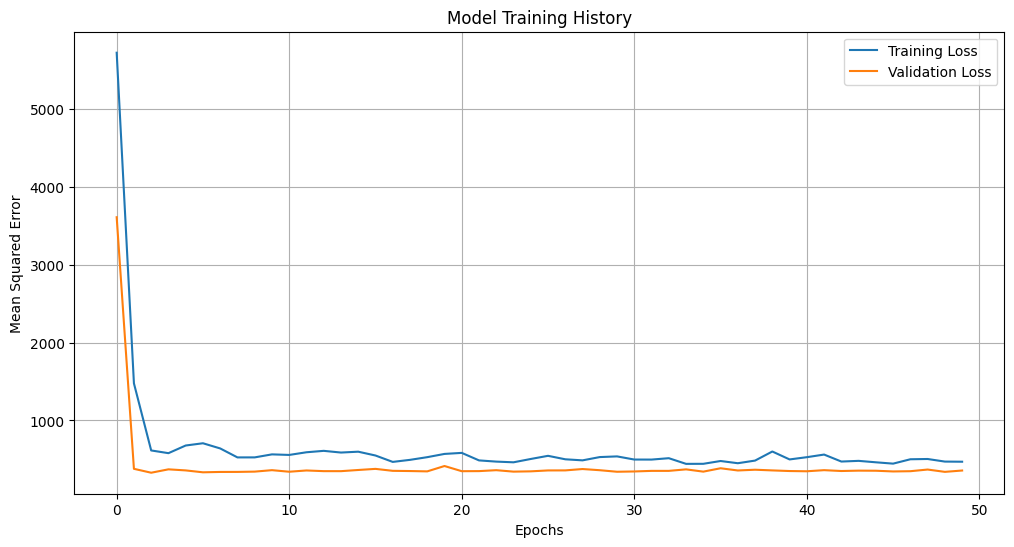

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

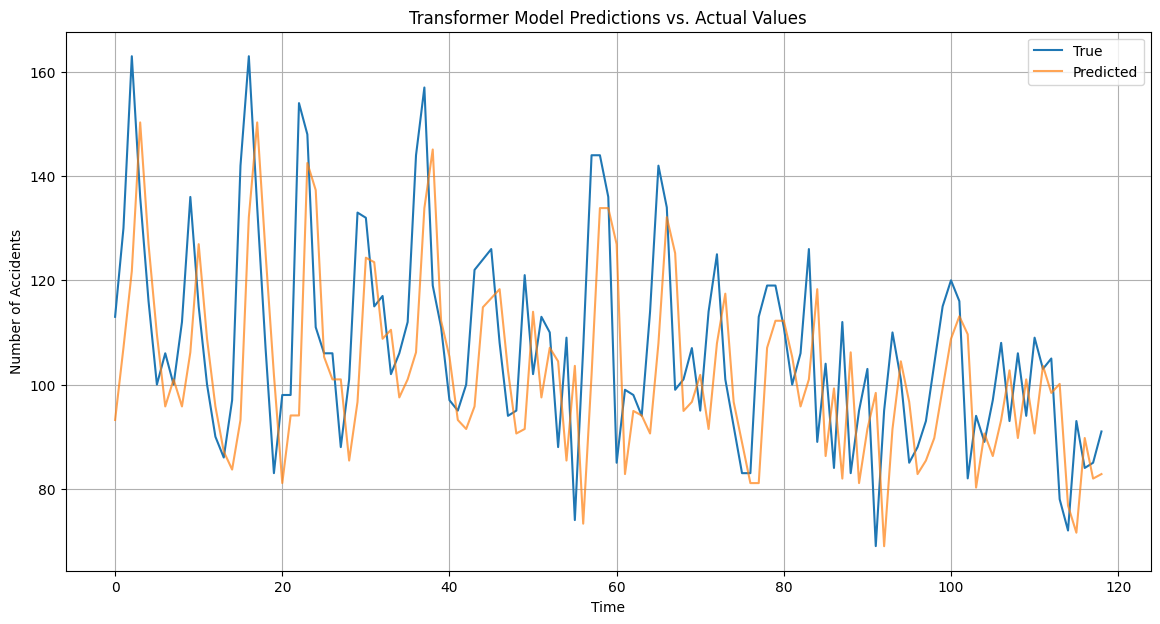

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(testY, label='True')
plt.plot(testPredict, label='Predicted', alpha=0.7)
plt.title('Transformer Model Predictions vs. Actual Values')
plt.xlabel('Time')
plt.ylabel('Number of Accidents')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model_arima = ARIMA(train, order=(5,1,0))
model_arima_fit = model_arima.fit()
arima_forecast = model_arima_fit.forecast(steps=len(test))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Assuming trainX and testX are already reshaped from previous steps
model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(look_back, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
model_lstm.fit(trainX, trainY, epochs=50, batch_size=8, verbose=2)
lstm_forecast = model_lstm.predict(testX)

Epoch 1/50
31/31 - 2s - loss: 9197.3350 - 2s/epoch - 60ms/step
Epoch 2/50
31/31 - 0s - loss: 8954.6836 - 91ms/epoch - 3ms/step
Epoch 3/50
31/31 - 0s - loss: 8553.3975 - 87ms/epoch - 3ms/step
Epoch 4/50
31/31 - 0s - loss: 7978.3169 - 98ms/epoch - 3ms/step
Epoch 5/50
31/31 - 0s - loss: 7679.4258 - 91ms/epoch - 3ms/step
Epoch 6/50
31/31 - 0s - loss: 7429.4019 - 87ms/epoch - 3ms/step
Epoch 7/50
31/31 - 0s - loss: 7166.4282 - 89ms/epoch - 3ms/step
Epoch 8/50
31/31 - 0s - loss: 6838.8779 - 102ms/epoch - 3ms/step
Epoch 9/50
31/31 - 0s - loss: 6575.1533 - 90ms/epoch - 3ms/step
Epoch 10/50
31/31 - 0s - loss: 6313.2661 - 88ms/epoch - 3ms/step
Epoch 11/50
31/31 - 0s - loss: 6114.1172 - 101ms/epoch - 3ms/step
Epoch 12/50
31/31 - 0s - loss: 5931.2598 - 90ms/epoch - 3ms/step
Epoch 13/50
31/31 - 0s - loss: 5760.8164 - 95ms/epoch - 3ms/step
Epoch 14/50
31/31 - 0s - loss: 5596.1548 - 95ms/epoch - 3ms/step
Epoch 15/50
31/31 - 0s - loss: 5416.9717 - 105ms/epoch - 3ms/step
Epoch 16/50
31/31 - 0s - loss: 5

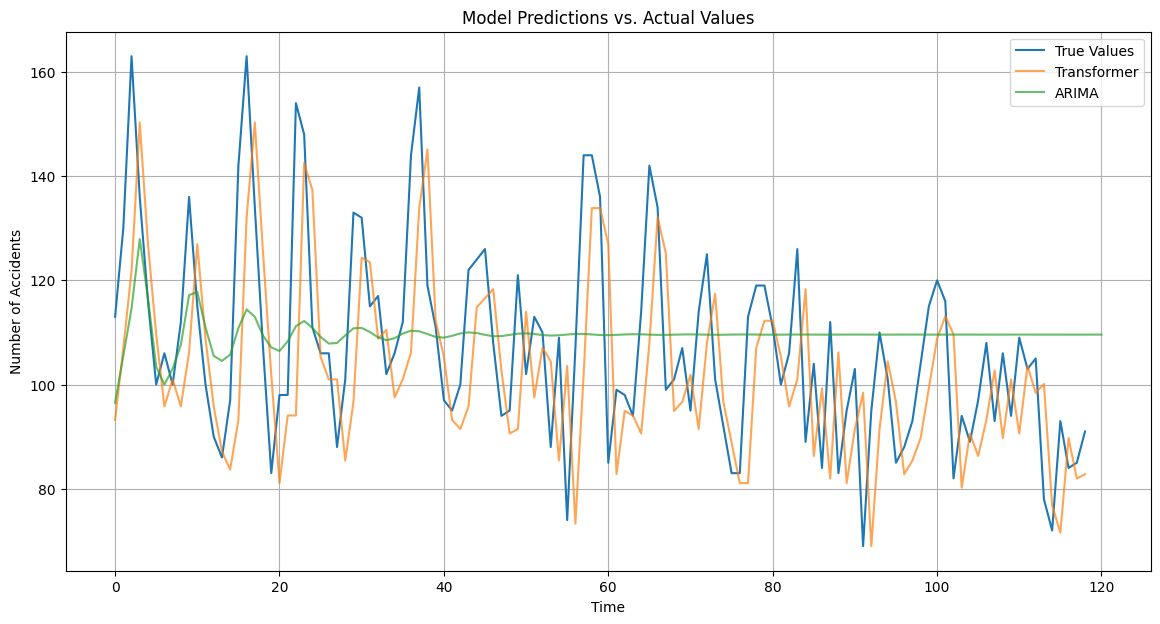

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(testY, label='True Values')
plt.plot(testPredict, label='Transformer', alpha=0.7)
plt.plot(arima_forecast.values, label='ARIMA', alpha=0.7)
#plt.plot(lstm_forecast, label='LSTM Predictions', alpha=0.7)
plt.title('Model Predictions vs. Actual Values')
plt.xlabel('Time')
plt.ylabel('Number of Accidents')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
!pip install prophet

DEBUG:cmdstanpy:input tempfile: /tmp/tmpnal14rgk/melpwq8n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnal14rgk/jnh0bcbc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69165', 'data', 'file=/tmp/tmpnal14rgk/melpwq8n.json', 'init=/tmp/tmpnal14rgk/jnh0bcbc.json', 'output', 'file=/tmp/tmpnal14rgk/prophet_modelquhk_spb/prophet_model-20231115000011.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:00:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:00:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


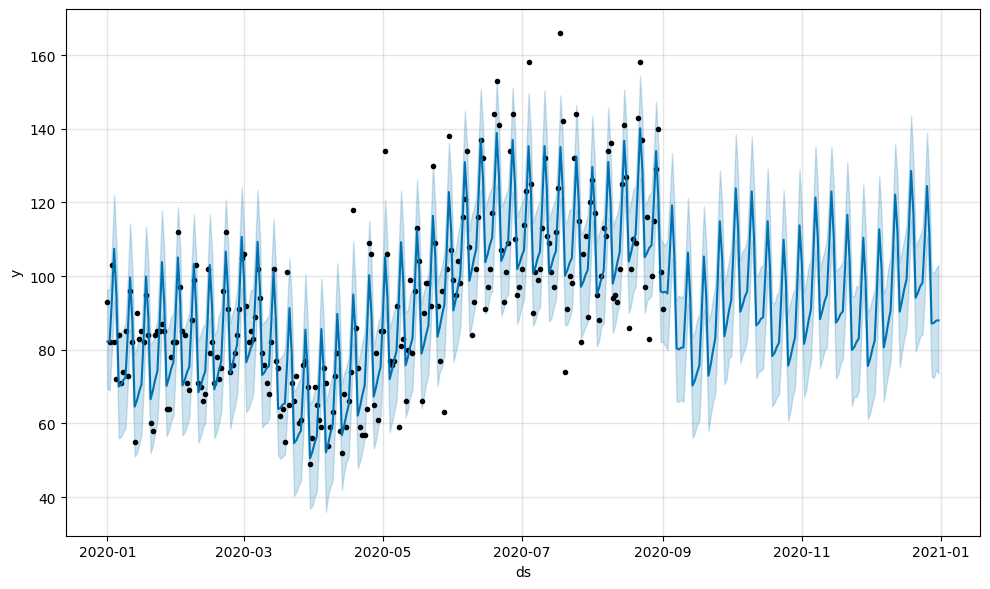

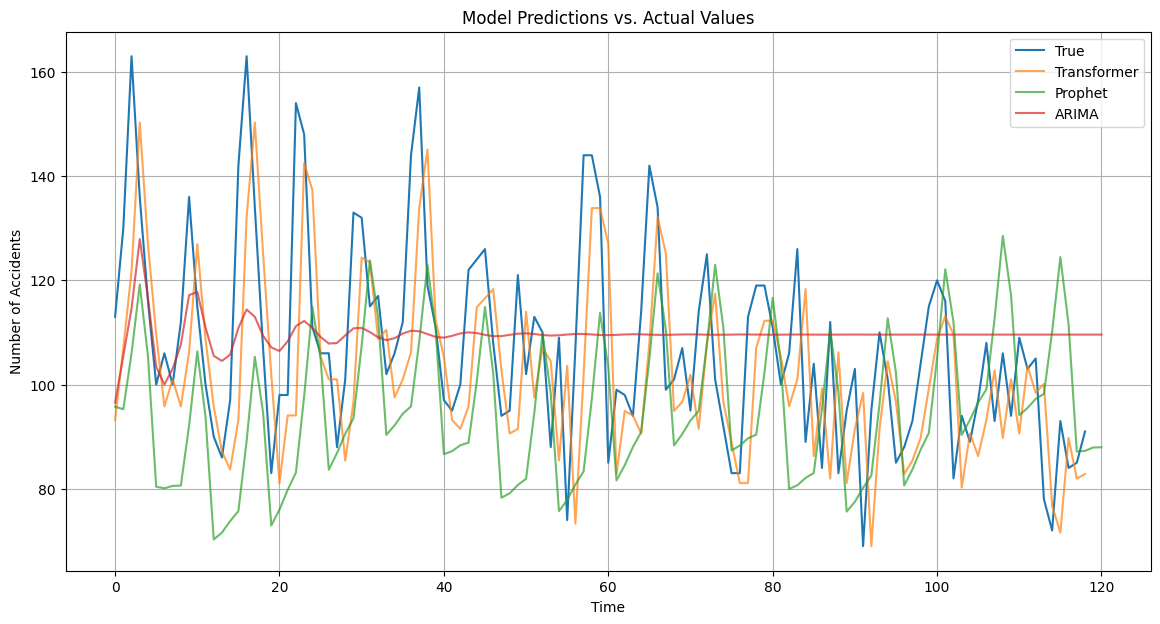

In [ ]:
from prophet import Prophet

# Preparing data in Prophet format
prophet_data = train.reset_index()
prophet_data.columns = ['ds', 'y']  # Prophet requires the column names to be ds and y

# Instantiate and fit the Prophet model
model_prophet = Prophet(yearly_seasonality=True, daily_seasonality=True)
model_prophet.fit(prophet_data)

# Make future dataframe
future = model_prophet.make_future_dataframe(periods=len(test))
forecast = model_prophet.predict(future)

# Plot the forecast
fig = model_prophet.plot(forecast)

# Extract predicted values
predicted = forecast['yhat'][-len(test):].values

# Plot actual vs predicted
plt.figure(figsize=(14, 7))
plt.plot(testY, label='True')
plt.plot(testPredict, label='Transformer', alpha=0.7)
plt.plot(predicted, label='Prophet', alpha=0.7)
plt.plot(arima_forecast.values, label='ARIMA', alpha=0.7)
plt.title('Model Predictions vs. Actual Values')
plt.xlabel('Time')
plt.ylabel('Number of Accidents')
plt.legend()
plt.grid(True)
plt.show()